In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt

from meval.stats import studentized_permut_pval
from meval.metrics import AUROC, Accuracy
from meval.group_filter import GroupFilter
from meval.config import settings

settings.update(N_test_permut=500)

N_rep = 1000

In [2]:
def simulate_equal_auroc_data(NA: int, NB: int):
    # These two groups have equal AUROC and unequal Accuracy at any threshold != 0.5
    scores_A = stats.beta.rvs(1, 2, size=NA)
    scores_B = 1 - stats.beta.rvs(1, 2, size=NB)
    labels_A = stats.bernoulli.rvs(scores_A)
    labels_B = stats.bernoulli.rvs(scores_B)
    return pd.DataFrame({
        'y_pred_prob': np.concat([scores_A, scores_B]),
        'y_true': np.concat([labels_A, labels_B]).astype(bool),
        'group': ['A'] * NA + ['B'] * NB
    })

In [3]:
def histogram_with_CIs(data, bins=15):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)  # Poisson errors
    # 99% Confidence Interval
    errors_99 = 2.576 * errors
    plt.figure()
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], 
            alpha=0.7, yerr=errors_99, capsize=3)
    plt.title("Histogram with Error Bars (Matplotlib)")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()

### Equal AUROC, mid-sized

In [4]:
group_filter = GroupFilter({'group': 'A'})

pvals = []
for ii in tqdm(range(N_rep)):
    # This is actually an interesting edge case because it will use newcombe for the small group variance and delong for the large group variance
    df = simulate_equal_auroc_data(NA=50, NB=200)
    pvals.append(studentized_permut_pval(df, AUROC(), group_filter, correct_zero_pvals=False)[0])

pvals = np.array(pvals)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [53:20<00:00,  3.20s/it]   


In [5]:
np.nanmean(pvals)

np.float64(0.483604)

In [6]:
np.nanmean(pvals < 0.05)  # should be very close to 0.05

np.float64(0.054)

In [7]:
np.isnan(pvals).sum()

np.int64(0)

In [8]:
# I think ?? that pvals in the case of a true null hypothesis should be uniformly distributed ??
stats.kstest(pvals, stats.uniform.cdf).pvalue

np.float64(0.09298528319117427)

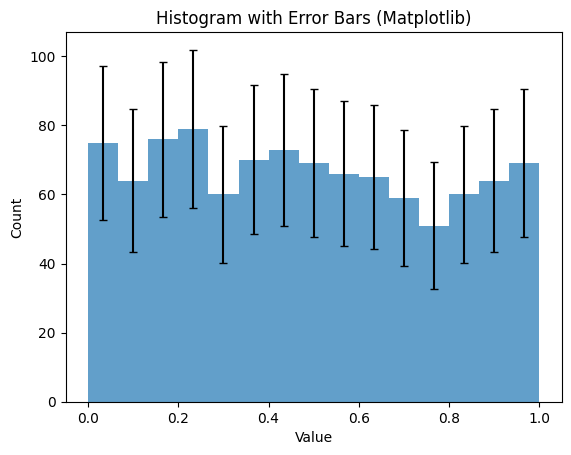

In [9]:
histogram_with_CIs(pvals[~np.isnan(pvals)])

### Equal AUROC, small-sized

In [10]:
pvals = []
for ii in tqdm(range(N_rep)):
    # This will all use Newcombe
    df = simulate_equal_auroc_data(NA=10, NB=20)
    pvals.append(studentized_permut_pval(df, AUROC(), group_filter, correct_zero_pvals=False)[0])

pvals = np.array(pvals)

100%|██████████| 1000/1000 [36:52<00:00,  2.21s/it]


In [11]:
np.nanmean(pvals)

np.float64(0.4217096336499322)

In [12]:
np.nanmean(pvals < 0.05)  # should ideally be very close to 0.05

np.float64(0.05)

In [13]:
np.isnan(pvals).sum() / len(pvals)

np.float64(0.263)

In [14]:
# I think ?? that pvals in the case of a true null hypothesis should be uniformly distributed ??
# So this pval should be >> 0
stats.kstest(pvals[~np.isnan(pvals)], stats.uniform.cdf).pvalue

np.float64(1.957915783308038e-11)

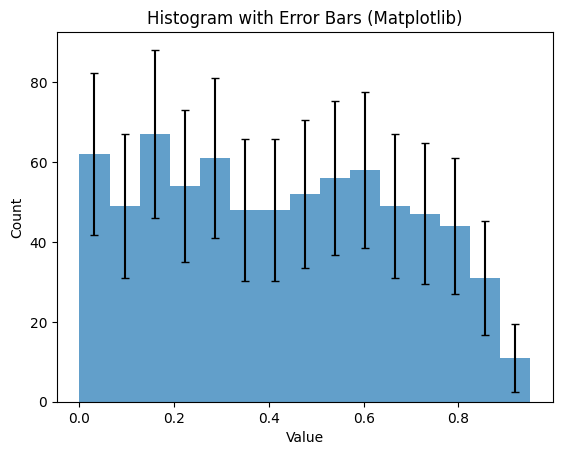

In [15]:
histogram_with_CIs(pvals[~np.isnan(pvals)])

### Equal AUROC, large-sized

In [16]:
pvals = []
for ii in tqdm(range(N_rep)):
    # This will all use DeLong
    df = simulate_equal_auroc_data(NA=1000, NB=2000)
    pvals.append(studentized_permut_pval(df, AUROC(), group_filter, correct_zero_pvals=False)[0])

pvals = np.array(pvals)

100%|██████████| 1000/1000 [1:23:17<00:00,  5.00s/it]


In [17]:
np.nanmean(pvals)

np.float64(0.510294)

In [18]:
np.nanmean(pvals < 0.05)  # should ideally be == 0.05

np.float64(0.044)

In [19]:
np.isnan(pvals).sum() / len(pvals)

np.float64(0.0)

In [20]:
# I think ?? that pvals in the case of a true null hypothesis should be uniformly distributed ??
stats.kstest(pvals[~np.isnan(pvals)], stats.uniform.cdf).pvalue

np.float64(0.45169720730901186)

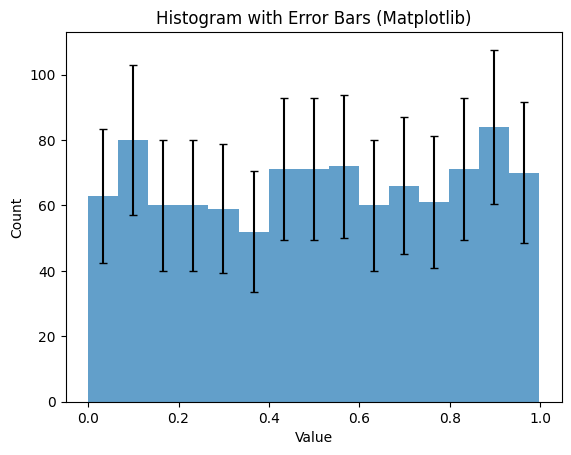

In [21]:
histogram_with_CIs(pvals[~np.isnan(pvals)])

### Unequal AUROC, mid-sized

In [22]:
def simulate_unequal_auroc_data(NA: int, NB: int):
    # These two groups have equal AUROC and unequal Accuracy at any threshold != 0.5
    true_scores_A = 1 - stats.beta.rvs(1, 2, size=int(NA/5))
    false_scores_A = stats.beta.rvs(1, 2, size=NA-len(true_scores_A))
    scores_A = np.concat([true_scores_A, false_scores_A])
    labels_A = np.concat([[True]*len(true_scores_A), [False]*len(false_scores_A)])
    scores_B = stats.uniform.rvs(0, 1, size=NB)
    labels_B = stats.bernoulli.rvs(0.5, size=NB)
    return pd.DataFrame({
        'y_pred_prob': np.concat([scores_A, scores_B]),
        'y_true': np.concat([labels_A, labels_B]).astype(bool),
        'group': ['A'] * NA + ['B'] * NB
    })

In [23]:
pvals = []
for ii in tqdm(range(N_rep)):
    df = simulate_unequal_auroc_data(NA=50, NB=200)
    pvals.append(studentized_permut_pval(df, AUROC(), group_filter, correct_zero_pvals=False)[0])

pvals = np.array(pvals)

100%|██████████| 1000/1000 [43:46<00:00,  2.63s/it]


In [24]:
np.nanmean(pvals)

np.float64(0.011380000000000001)

In [25]:
np.nanmean(pvals < 0.05)  # should ideally be much larger than 0.05

np.float64(0.942)

In [26]:
np.isnan(pvals).sum() / len(pvals)

np.float64(0.0)

In [27]:
stats.kstest(pvals[~np.isnan(pvals)], stats.uniform.cdf).pvalue

np.float64(0.0)

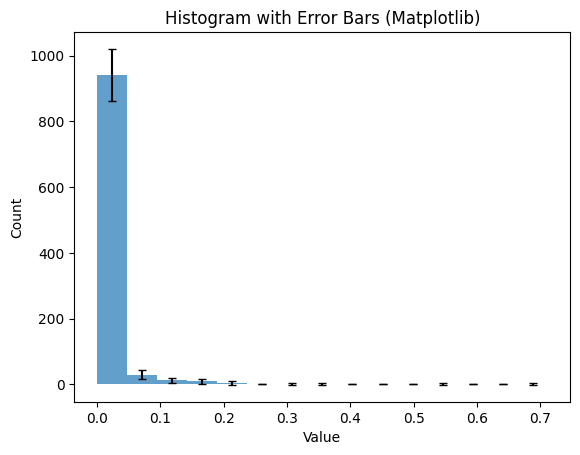

In [28]:
histogram_with_CIs(pvals[~np.isnan(pvals)])

### Unequal AUROC, small-sized

In [29]:
pvals = []
for ii in tqdm(range(N_rep)):
    df = simulate_unequal_auroc_data(NA=10, NB=20)
    pvals.append(studentized_permut_pval(df, AUROC(), group_filter, correct_zero_pvals=False)[0])

pvals = np.array(pvals)

100%|██████████| 1000/1000 [40:17<00:00,  2.42s/it]


In [30]:
np.nanmean(pvals)

np.float64(0.2910777777777777)

In [31]:
np.nanmean(pvals < 0.05)  # should ideally be much larger than 0.05

np.float64(0.152)

In [32]:
np.isnan(pvals).sum() / len(pvals)

np.float64(0.28)

In [33]:
stats.kstest(pvals[~np.isnan(pvals)], stats.uniform.cdf).pvalue

np.float64(2.687714750038573e-68)

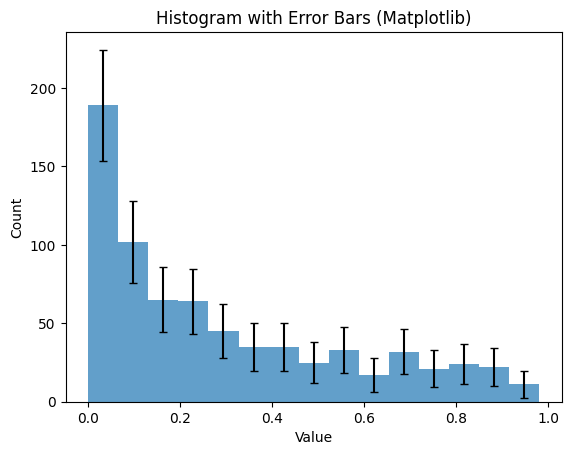

In [34]:
histogram_with_CIs(pvals[~np.isnan(pvals)])

### Unequal Accuracy, mid-sized

In [35]:
pvals = []
for ii in tqdm(range(N_rep)):
    df = simulate_unequal_auroc_data(NA=50, NB=200)
    pvals.append(studentized_permut_pval(df, Accuracy(threshold=0.5), group_filter, correct_zero_pvals=False)[0])

pvals = np.array(pvals)

100%|██████████| 1000/1000 [10:55<00:00,  1.53it/s]


In [36]:
np.nanmean(pvals)

np.float64(0.015644)

In [37]:
np.nanmean(pvals < 0.05)  # should ideally be much larger than 0.05

np.float64(0.929)

In [38]:
np.isnan(pvals).sum() / len(pvals)

np.float64(0.0)

In [39]:
stats.kstest(pvals[~np.isnan(pvals)], stats.uniform.cdf).pvalue

np.float64(0.0)

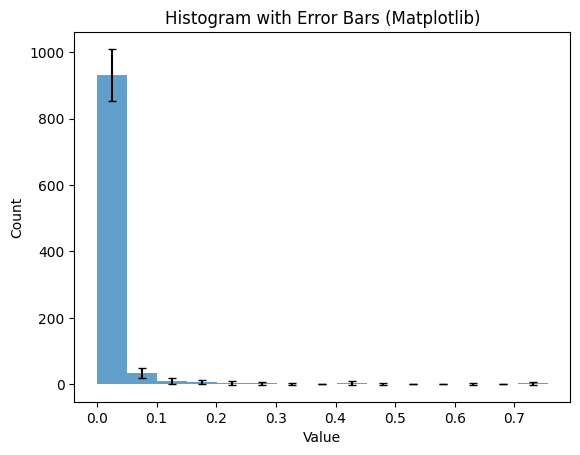

In [40]:
histogram_with_CIs(pvals[~np.isnan(pvals)])

### Unequal Accuracy, small-sized

In [41]:
pvals = []
for ii in tqdm(range(N_rep)):
    df = simulate_unequal_auroc_data(NA=10, NB=20)
    pvals.append(studentized_permut_pval(df, Accuracy(threshold=0.5), group_filter, correct_zero_pvals=False)[0])

pvals = np.array(pvals)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


In [42]:
np.nanmean(pvals)

np.float64(0.20448261327713382)

In [43]:
np.nanmean(pvals < 0.05)  # should ideally be much larger than 0.05

np.float64(0.31)

In [44]:
np.isnan(pvals).sum() / len(pvals)

np.float64(0.051)

In [45]:
stats.kstest(pvals[~np.isnan(pvals)], stats.uniform.cdf).pvalue

np.float64(4.730176257937861e-200)

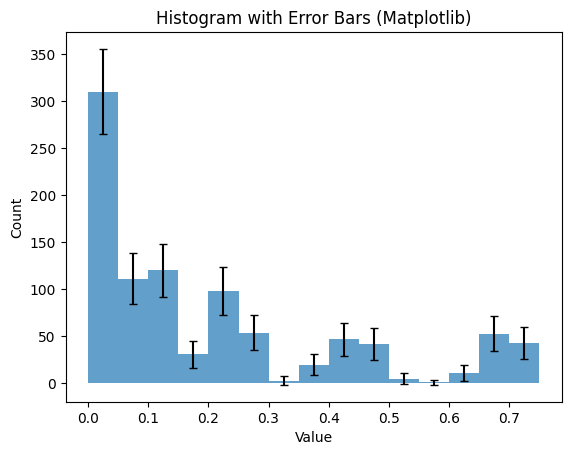

In [46]:
histogram_with_CIs(pvals[~np.isnan(pvals)])